# multi-classifier

based on http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

Explore different classifiers on our isa dataset

In [1]:
%matplotlib inline


### First let's run the original example

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loa

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 0.462s
test time:  0.002s
accuracy:   0.897
dimensionality: 33809
density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.193s
test time:  0.006s
accuracy:   0.885
dimensionality: 33809
density: 0.240165


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
train time: 0.170s
test time:  0.003s
accuracy:   0.902
dimensionality: 33809
density: 0.701307


kNN
________________________________________________________________________________
Training: 
KNeighborsClassif

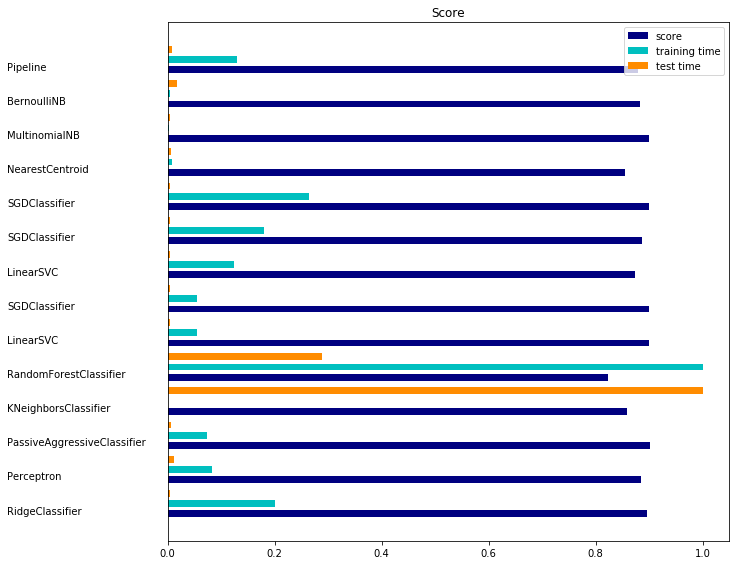

In [3]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()


# #############################################################################
# Load some categories from the training set
if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
# The following cell pulls down large datasets from fetch_20newsgroups.
# Skip if you don't need to compare with our use case

### See what data format it expects

In [10]:
data_train['data'][0:2]

["From: rych@festival.ed.ac.uk (R Hawkes)\nSubject: 3DS: Where did all the texture rules go?\nLines: 21\n\nHi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych\n\n======================================================================\nRycharde Hawkes\t\t\t\temail: rych@festival.ed.ac.uk\nVirtual Environment Laboratory\nDept. of Psychology\t\t\tTel  : +44 31 650 3426\nUniv. of Edinburgh\t\t\tFax  : +44 31 667 0150\n=============

In [11]:
print(type(data_train))

<class 'sklearn.datasets.base.Bunch'>


In [10]:
y_train[0:4]

array([1, 3, 2, 0])

In [5]:
X_train

<2034x33809 sparse matrix of type '<type 'numpy.float64'>'
	with 224893 stored elements in Compressed Sparse Row format>

In [59]:
# If you want a smaller set use etl.load('../ml_challenge/<filename>) 
#data_set = etl.load_dir('../ml_challenge')
# handy when developing etl in this notebook
from importlib import reload
if 'etl' in globals():
    reload(etl)
else:
    import etl
data_set = etl.load_dir('../ml_challenge/')

In [60]:
orig_X_train, orig_Y_train, orig_train_targets = data_set['train']['binary_data'], data_set['train']['answers'], data_set['train']['targets']
orig_X_dev, orig_Y_dev, orig_dev_targets = data_set['dev']['binary_data'], data_set['dev']['answers'], data_set['dev']['targets']
orig_X_test, orig_Y_test, orig_test_targets = data_set['test']['binary_data'], data_set['test']['answers'], data_set['test']['targets']

print('orig_X_train[0:4]', '\n', orig_X_train[0:4])
print('orig_Y_train[0:4]', '\n', orig_Y_train[0:4])
print('orig_train_targets[0:4]', '\n', orig_train_targets[0:4])

orig_X_train[0:4] 
 ['AADtjAAywX8ADD0gAADACQAA7AsAMuwMACj9gAIQPSAAAMAJAAD/jAAAQJ0ADMAfAAhIAAAQwZ8ACMAfAAzsDA==', 'AAb/////AAAAAAADbGx4CgAgAJgLAKkRwCAAmBuQkPWgmSDAIACZCMAgAJgrwCAAmQjBAADRAAChAACBAADgCA==', 'jIkAGI1LAACNaQAAAShIJK1pAACMSQAgJSkAARAA//GsSQAgjUIAAK+iABiMwgAIAAAwIYxCAACsogAMPAIAAA==', 'WDAwAFAwEACnSAAAWDDR4lBAEABYQNHeUEAQAFhAMABQQBAAWEAwBFBAEABYQNHaWDAwCFAwEABYMEAAUDAQAA==']
orig_Y_train[0:4] 
 ['powerpc', 'xtensa', 'mips', 's390']
orig_train_targets[0:4] 
 [['alphaev56', 'arm', 'powerpc', 's390', 'sh4', 'xtensa'], ['alphaev56', 'avr', 'mipsel', 'powerpc', 'sh4', 'xtensa'], ['avr', 'm68k', 'mips', 'powerpc', 'sh4', 'sparc'], ['arm', 'avr', 'm68k', 'mips', 'mipsel', 's390']]


In [61]:
hex_X_train = etl.hex_data(orig_X_train)
hex_X_dev = etl.hex_data(orig_X_dev)
hex_X_test = etl.hex_data(orig_X_test)

print('hex_X_train[0:4]', hex_X_train[0:4], '\n')


hex_X_train[0:4] [ '0000ed8c0032c17f000c3d200000c0090000ec0b0032ec0c0028fd8002103d200000c0090000ff8c0000409d000cc01f000848000010c19f0008c01f000cec0c'
 '0006ffffffff0000000000036c6c780a002000980b00a911c02000981b9090f5a09920c020009908c02000982bc020009908c10000d10000a10000810000e008'
 '8c8900188d4b00008d69000001284824ad6900008c490020252900011000fff1ac4900208d420000afa200188cc20008000030218c420000aca2000c3c020000'
 '5830300050301000a74800005830d1e2504010005840d1de50401000584030005040100058403004504010005840d1da58303008503010005830400050301000'] 



In [7]:
# The order of classes from CountVectorizer.classes_ may be different from etl.SUPPORTED_ARCHITECTURES
# We will over-write y_train and y_dev below with .classes_
y_train = list(map(etl.SUPPORTED_ARCHITECTURES.index, orig_Y_train))
y_dev = list(map(etl.SUPPORTED_ARCHITECTURES.index, orig_Y_dev))

In [8]:
print(y_train[0:4], len(y_train))
print(y_dev[0:4], len(y_dev))

[8, 10, 4, 2] 2048
[5, 3, 11, 1] 256


In [14]:
import re

In [31]:
2**16

65536

In [ ]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause
debug = True

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories", default=True,
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()


# #############################################################################


# order of labels in `target_names` can be different from `categories`
target_names = etl.SUPPORTED_ARCHITECTURES


def size_mb(docs):
    return sum(len(s) for s in docs) / 1e6

data_train_size_mb = size_mb(hex_X_train)
data_test_size_mb = size_mb(hex_X_dev)

print("%d documents - %0.3fMB (training set)" % (
    len(hex_X_train), data_train_size_mb))
print("%d documents - %0.3fMB (dev set)" % (
    len(hex_X_dev), data_test_size_mb))
print()

# rename until we make this a function
X_train = hex_X_train
X_test = hex_X_dev

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(X_train)
else:
    vec_opts = {
        "ngram_range": (1, 6),  # allow n-grams of 1-4 words in length (32-bits)
        "analyzer": "word",     # analyze hex words
        "token_pattern": "..",  # treat two characters as a word (e.g. 4b)
        "min_df": 2,          # 
        "max_df": 0.7,
    }
    #v = CountVectorizer(**vec_opts)
    #X_train = v.fit_transform(X_train)

    idf_opts = {"use_idf": True}
    #vectorizer = TfidfTransformer(**idf_opts)
    vec_opts.update(idf_opts)
    vectorizer = TfidfVectorizer(**vec_opts)
    X_train = vectorizer.fit_transform(X_train)
    
print('list(v.vocabulary_.items())[0:10]', list(v.vocabulary_.items())[0:10])    
    
print("vocabulary size: {}".format(len(v.vocabulary_)))
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
#vec_opts.update({'vocabulary': v.vocabulary_})
#v_test = CountVectorizer(**vec_opts)
#X_test = v_test.fit_transform(X_test)
X_test = vectorizer.transform(X_test)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

# split a training set and a test set
# y_train = list(map(v.classes_.index, orig_Y_train))
# y_test = list(map(v.classes_.index, orig_Y_dev))
# print('y_train[0:4]', y_train[0:4], 'y_test[0:4]', y_test[0:4])

if False: #opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."




# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, X_test, y_train, y_test):
    """
    @param X_train: tfid vectorized x input training data
    @param X_test: tfid vectorized x input test data
    """
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    print('X_train.shape', X_train.shape, "y_train.shape", len(y_train))
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    if debug:
        print("Some samples")
        print("y_test[0:3]", y_test[0:3], "pred[0:3]", pred[0:3])
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train, X_test, orig_Y_train, orig_Y_dev))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3), X_train, X_test, orig_Y_train, orig_Y_dev))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty), X_train, X_test, orig_Y_train, orig_Y_dev))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet"), X_train, X_test, orig_Y_train, orig_Y_dev))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid(), X_train, X_test, orig_Y_train, orig_Y_dev))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01), X_train, X_test, orig_Y_train, orig_Y_dev))
results.append(benchmark(BernoulliNB(alpha=.01), X_train, X_test, orig_Y_train, orig_Y_dev))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))]), X_train, X_test, orig_Y_train, orig_Y_dev))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.

28160 documents - 3.604MB (training set)
3584 documents - 0.459MB (dev set)

Extracting features from the training data us

In [55]:
import pandas as pd
dfr = pd.DataFrame(results).transpose()
dfr.columns=['classifier', 'accuracy', 'train_time', 'test_time']

In [56]:
dfr

,classifier,accuracy,train_time,test_time
0,RidgeClassifier,0.996094,1.01744,0.00252819
1,Perceptron,0.988281,0.547086,0.00270653
2,PassiveAggressiveClassifier,0.992188,1.56262,0.00758171
3,KNeighborsClassifier,0.984375,0.00676441,0.202344
4,RandomForestClassifier,0.980469,2.62882,0.0496018
5,LinearSVC,0.996094,0.689969,0.00208521
6,SGDClassifier,0.996094,0.598987,0.00243831
7,LinearSVC,0.984375,1.00739,0.00111461
8,SGDClassifier,0.988281,1.5408,0.00335622
9,SGDClassifier,0.992188,1.85088,0.00254416


In [57]:
dfr.describe()

,classifier,accuracy,train_time,test_time
count,14,14.000000,14.000000,14.000000
unique,11,6.000000,14.000000,14.000000
top,SGDClassifier,0.996094,1.562622,0.004128
freq,3,4.000000,1.000000,1.000000
